# Testing networks for $F$ and $G$ term in `StabNODE`

In [1]:
from stabnode.node import Felu, Gelu, StabNODE, model_trainer
from stabnode.node import set_global_seed, _load_model_opt
from data.hysteresis import simulate_steady_state
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'

# set_global_seed(1234)


In [2]:
# Load data in the same way 
def load_data(seed, sample_rate):
    set_global_seed(seed = seed)
    
    lam_start = -1 
    lam_end = 1
    
    n_points = 250
    
    lam_increase = np.linspace(lam_start,lam_end, n_points)
    lam_decrease = np.linspace(lam_end, lam_start, n_points)
    
    x0=-1
    
    simulate_time = (0.,50.)
    
    x_increase = simulate_steady_state(lam_increase, x0, simulate_time,show_progress=True)
    x_decrease = simulate_steady_state(lam_decrease, x_increase[-1],simulate_time, show_progress=True)
    
    X = np.hstack((x_increase, x_decrease))
    lam = np.hstack((lam_increase, lam_decrease))
    repeat = 2
    
    for _ in range(repeat):
        X = np.hstack((X,X))
        lam = np.hstack((lam, lam))
    
    tau = torch.arange(0,len(lam),device=device)
    t = (tau+1)*simulate_time[-1]
    
    scaler = MinMaxScaler(feature_range=(-1,1))
    X_scaled = scaler.fit_transform(X.reshape(-1,1))
    X_scaled = torch.tensor(X_scaled,dtype=torch.float32, device=device)
    
    # sample_rate = 10
    tau_train = tau[::sample_rate]
    X_train = X_scaled[tau_train]
    lam_train = lam[tau_train]

    def lam_func(tau):
        idx = int(tau) % len(lam)
        return torch.tensor(lam[idx],dtype=torch.float32, device=device)
    
    return X, lam, tau, t, scaler, X_scaled, tau_train, X_train, lam_train, lam_func

In [3]:
X, lam, tau, t, scaler, X_scaled, tau_train, X_train, lam_train, lam_func = load_data(1234,sample_rate=1)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

In [4]:
dim_in = X_train.shape[-1]
dim_out = X_train.shape[-1]

f_hidden_dim = 2
g_hidden_dim = 6
f = Felu(dim_in,dim_out, f_hidden_dim)
g = Gelu(dim_in+1, dim_out,g_hidden_dim)

model = StabNODE(f,g)
model.to(device)

StabNODE(
  (f): Felu(
    (network): Sequential(
      (0): Linear(in_features=1, out_features=2, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=2, out_features=1, bias=True)
    )
  )
  (g): Gelu(
    (network): Sequential(
      (0): Linear(in_features=2, out_features=6, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=6, out_features=1, bias=True)
      (3): Tanh()
    )
  )
)

In [5]:
loss_criteria = nn.MSELoss()
opt = torch.optim.Adam(list(f.parameters())+list(g.parameters()), lr = 0.1)
tau_span = tau_train.clone().detach().to(dtype=torch.float32, device=device)
x0 = X_train[0].reshape(-1, 1).clone().detach().to(dtype=torch.float32,device=device)
x0.requires_grad_(True)

tensor([[-1.]], requires_grad=True)

In [6]:
n_epochs = 200
model, log_history = model_trainer(
              model,
              opt,
              loss_criteria,
              x0,
              tau_span,
              X_train,
              lam_func,
              n_epochs=n_epochs,
              min_improvement=1e-4,
              patience=100,
              print_every=10,
              solve_method='rk4',
              show_progress=True,
              save_path=None)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0: Loss = 0.7549, time = 3.6611
Epoch 1: Loss = 0.5809, time = 3.9679
Epoch 2: Loss = 0.4564, time = 4.2243
Epoch 3: Loss = 0.3345, time = 4.2434
Epoch 4: Loss = 0.2411, time = 4.0819
Epoch 5: Loss = 0.2077, time = 4.2854
Epoch 10: Loss = 0.1007, time = 4.1908
Epoch 20: Loss = 0.0450, time = 4.2563
Epoch 30: Loss = 0.0403, time = 4.1922
Epoch 40: Loss = 0.0373, time = 4.2780
Epoch 50: Loss = 0.0312, time = 4.2099
Epoch 60: Loss = 0.0298, time = 4.2546
Epoch 70: Loss = 0.0292, time = 4.2476
Epoch 80: Loss = 0.0285, time = 4.2420
Epoch 90: Loss = 0.0279, time = 4.2587
Epoch 100: Loss = 0.0272, time = 4.2567
Epoch 110: Loss = 0.0263, time = 4.2012
Epoch 120: Loss = 0.0251, time = 4.2529
Epoch 130: Loss = 0.0233, time = 4.2117
Epoch 140: Loss = 0.0335, time = 4.1686
Epoch 150: Loss = 0.0396, time = 4.1833
Epoch 160: Loss = 0.0230, time = 4.2027
Epoch 170: Loss = 0.0184, time = 4.1635
Epoch 180: Loss = 0.0155, time = 4.1361
Epoch 190: Loss = 0.0138, time = 4.1080


In [7]:
def g_true(x,lam):
    return (1/x)*((lam / x)  + 1)

def f_true(x):
    return -x**2

def evaluate_model(model, X, lam, tau, t, scaler, X_scaled, tau_train, X_train, lam_train, lam_func):
    g = model.g
    f = model.f
    
    g.eval()
    f.eval()
    
    g_true_out = []
    g_pred_out = []
    
    f_true_out = []
    f_pred_out = []
    print(tau)
    for tau_i in tau:
    
        lam_i = lam_func(tau_i).reshape(-1,1)
        xi = X_scaled[tau_i].reshape(-1,1)
        xi_unscaled = X[tau_i].reshape(-1,1)
    
        g_true_out.append(g_true(xi_unscaled,lam_i.numpy()))
        f_true_out.append(f_true(xi_unscaled))
    
        with torch.no_grad():
            g_pred_out.append(g(xi,lam_i).detach().cpu().numpy())
            f_pred_out.append(f(xi).detach().cpu().numpy())
    
    g_true_out = np.array(g_true_out).reshape(-1)
    g_pred_out = np.array(g_pred_out).reshape(-1)
    
    f_true_out = np.array(f_true_out).reshape(-1)
    f_pred_out = np.array(f_pred_out).reshape(-1)
    
    finite_idx = np.isfinite(g_true_out)
    g_true_scaled = scaler.transform(g_true_out[finite_idx].reshape(-1,1)).reshape(-1)

    finite_idx = np.isfinite(f_true_out)
    f_true_scaled = scaler.transform(f_true_out[finite_idx].reshape(-1,1)).reshape(-1)

    
    
    L2_rel_err = np.linalg.norm(g_true_scaled - g_pred_out) / np.linalg.norm(g_true_scaled)

    return g_true_scaled, g_pred_out, tau_train, X_train, L2_rel_err, f_true_scaled, f_pred_out, f_true_out

In [8]:
true = []
pred = []
taus = []
train = []
l2 = []


g_true_scaled, g_pred_out, tau_train, X_train, L2_rel_err, f_true_scaled, f_pred_out, f_true_out= evaluate_model(model,  X, lam, tau, t, scaler, X_scaled, tau_train, X_train, lam_train, lam_func)
true.append(g_true_scaled)
pred.append(g_pred_out)
taus.append(tau_train)
train.append(X_train)
l2.append(L2_rel_err)

tensor([   0,    1,    2,  ..., 1997, 1998, 1999])


In [12]:
idx = 0
# plt.plot(true[0], label='g true')
# plt.plot(pred[0], linestyle='--',label = 'g node')
# # plt.scatter(tau[0], train[0], label ='measurements')
# plt.title(f"Sample size {2000//1}, Adam lr={0.1}\nrel L2 err = {l2[idx]:.4f}, Latent dim = {g_hidden_dim}", family='serif',size=15)
# plt.legend(prop={'family': 'serif'})
# plt.grid(True)
# plt.show()

In [13]:
# # plt.plot(f_true_out, label="true")
# l2_err = np.linalg.norm(f_true_scaled - f_pred_out) / np.linalg.norm(f_true_scaled)

# plt.plot(f_true_scaled, label='f true')
# plt.plot(f_pred_out, linestyle='--',label='f node')
# plt.title(f"Learning f node, rel L2 err: {l2_err:.3f}, latent dim={f_hidden_dim}", family='serif',size=20)
# plt.legend(prop={'family':'serif'})
# plt.grid(True)
# plt.show()

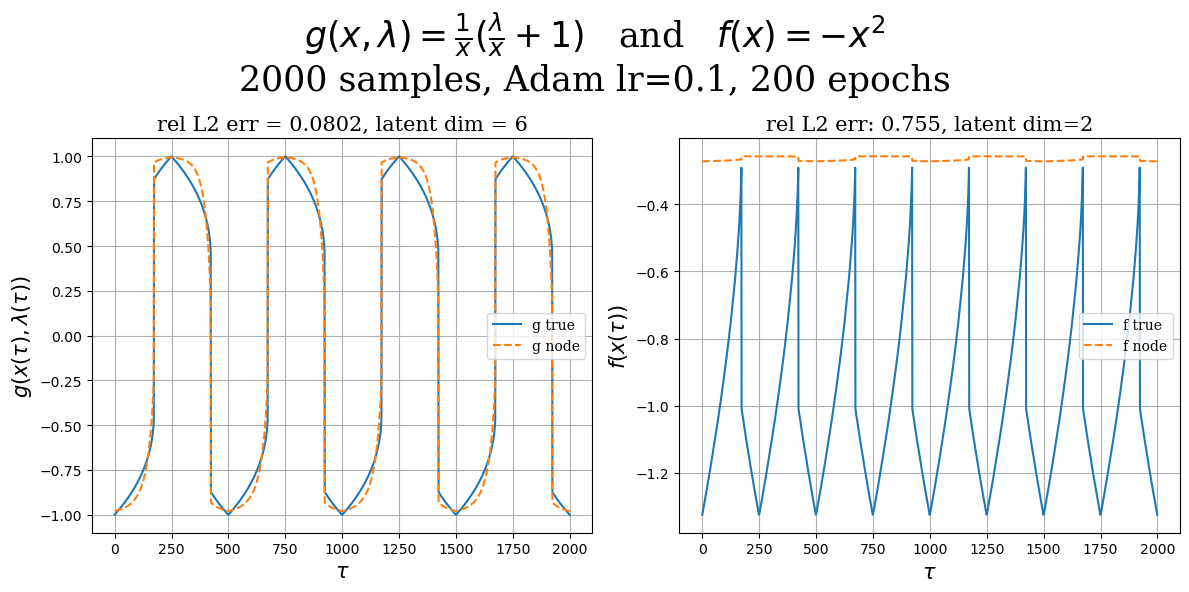

In [14]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,6))

ax1.plot(true[0], label='g true')
ax1.plot(pred[0], linestyle='--',label = 'g node')
ax1.set_title(f"rel L2 err = {l2[idx]:.4f}, latent dim = {g_hidden_dim}", family='serif',size=15)
ax1.set_xlabel(r"$\tau$",family='serif',size=15)
ax1.set_ylabel(r"$g(x(\tau),\lambda(\tau))$", size = 15)
ax1.legend(prop={'family': 'serif'},)
ax1.grid(True)


l2_err = np.linalg.norm(f_true_scaled - f_pred_out) / np.linalg.norm(f_true_scaled)

ax2.plot(f_true_scaled, label='f true')
ax2.plot(f_pred_out, linestyle='--',label='f node')
ax2.set_title(f"rel L2 err: {l2_err:.3f}, latent dim={f_hidden_dim}", family='serif',size=15)
ax2.legend(prop={'family':'serif'}, )
ax2.set_xlabel(r"$\tau$", size=15)
ax2.set_ylabel(r"$f(x(\tau))$",size=15)
ax2.grid(True)


plt.suptitle(r"$g(x,\lambda) = \frac{1}{x}(\frac{\lambda}{x}+1)$   and   $f(x) = -x^2$"+f"\n2000 samples, Adam lr=0.1, {n_epochs} epochs",family='serif',size=25)
plt.tight_layout()
plt.savefig("g_and_f_elu_learning.png")
plt.show()

In [ ]:
losses = np.array(log_history['losses'])
plt.plot(losses)
plt.yscale('log')
plt.grid(True)
plt.show()

In [ ]:
losses[log_history['best_model_epoch']] - losses[-20:], 1e-4

In [ ]:
plt.plot(log_history['patience_hist'])
plt.show()

In [ ]:
# log_history['patience_hist']